In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow import keras 
import tensorflow_datasets as tfds
import os
import pickle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras_tqdm import TQDMNotebookCallback
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
gpu = tf.config.list_physical_devices('GPU')
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load Cifar 10

In [3]:
ds = tf.keras.datasets.cifar10.load_data()
img_size = (32,32,3)

In [4]:
(X_train, y_train), (X_test, y_test) = ds
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_val = tf.keras.utils.to_categorical(y_val)

X_train = X_train / 255.0 
X_test = X_test / 255.0 
X_val = X_val / 255.0

In [5]:
print(f"X_train : {X_train.shape}") 
print(f"X_val : {X_val.shape}") 
print(f"X_test : {X_test.shape}")

X_train : (40000, 32, 32, 3)
X_val : (10000, 32, 32, 3)
X_test : (10000, 32, 32, 3)


In [6]:
class ShallowNet: 
    
    @staticmethod
    def build(w, h, chanels, classes): 
        inputShape = (w, h , chanels) 
        inputs = tf.keras.Input(shape=inputShape) 
        print(inputs)
        x = tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu")(inputs) 
        x = tf.keras.layers.Flatten()(x)
        outputs = tf.keras.layers.Dense(classes, activation="softmax")(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

In [10]:
optimizer = tf.keras.optimizers.SGD(lr=0.005)
w, h, c = X_train[0].shape

In [109]:
model = ShallowNet().build(w, h, c, 10)
# compile : loss, metrics, optimizer
model.compile(optimizer=optimizer, metrics=["accuracy"], loss="CategoricalCrossentropy")
# fit : data, epoch, batch_size
history = model.fit(x=X_train,y=y_train, epochs=50, verbose=2, validation_data=(X_test, y_test))

Epoch 1/50
1250/1250 - 5s - loss: 1.9124 - accuracy: 0.3228 - val_loss: 1.7635 - val_accuracy: 0.3788
Epoch 2/50
1250/1250 - 4s - loss: 1.7198 - accuracy: 0.4049 - val_loss: 1.6690 - val_accuracy: 0.4174
Epoch 3/50
1250/1250 - 4s - loss: 1.6253 - accuracy: 0.4379 - val_loss: 1.5807 - val_accuracy: 0.4476
Epoch 4/50
1250/1250 - 4s - loss: 1.5356 - accuracy: 0.4686 - val_loss: 1.4987 - val_accuracy: 0.4800
Epoch 5/50
1250/1250 - 4s - loss: 1.4537 - accuracy: 0.4967 - val_loss: 1.4360 - val_accuracy: 0.5026
Epoch 6/50
1250/1250 - 4s - loss: 1.3886 - accuracy: 0.5173 - val_loss: 1.4067 - val_accuracy: 0.5064
Epoch 7/50
1250/1250 - 4s - loss: 1.3396 - accuracy: 0.5321 - val_loss: 1.3785 - val_accuracy: 0.5152
Epoch 8/50
1250/1250 - 4s - loss: 1.3018 - accuracy: 0.5476 - val_loss: 1.3316 - val_accuracy: 0.5241
Epoch 9/50
1250/1250 - 4s - loss: 1.2723 - accuracy: 0.5573 - val_loss: 1.3204 - val_accuracy: 0.5300
Epoch 10/50
1250/1250 - 4s - loss: 1.2488 - accuracy: 0.5664 - val_loss: 1.3121 - 

## Metrics

In [110]:
preds = model.predict(X_val)
target_names = [f"classe_{i}" for i in range(len(y_test[0]))]
print(classification_report(y_val.argmax(axis=1), preds.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

    classe_0       0.62      0.64      0.63      1024
    classe_1       0.70      0.71      0.70      1017
    classe_2       0.55      0.33      0.41       944
    classe_3       0.44      0.28      0.34      1002
    classe_4       0.49      0.47      0.48       981
    classe_5       0.46      0.47      0.47       961
    classe_6       0.46      0.81      0.59       980
    classe_7       0.72      0.58      0.64       994
    classe_8       0.64      0.75      0.69      1035
    classe_9       0.67      0.65      0.66      1062

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.56     10000
weighted avg       0.58      0.57      0.56     10000



In [27]:
def plot_model_evaluation(history, epoch, title): 
    plt.figure(figsize=(10,10))
    plt.plot(np.arange(0,epoch), history.history["loss"], label="Loss")
    plt.plot(np.arange(0, epoch), history.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0,epoch), history.history["val_loss"], label="val_Loss")
    plt.plot(np.arange(0, epoch), history.history["val_accuracy"], label="val_accuracy")
    plt.grid()
    plt.xlabel("Epochs") 
    plt.ylabel("Loss / Accuracy")
    plt.legend()
    plt.title(f"Model evaluation on CIFAR-10 | {title}")
    plt.show()

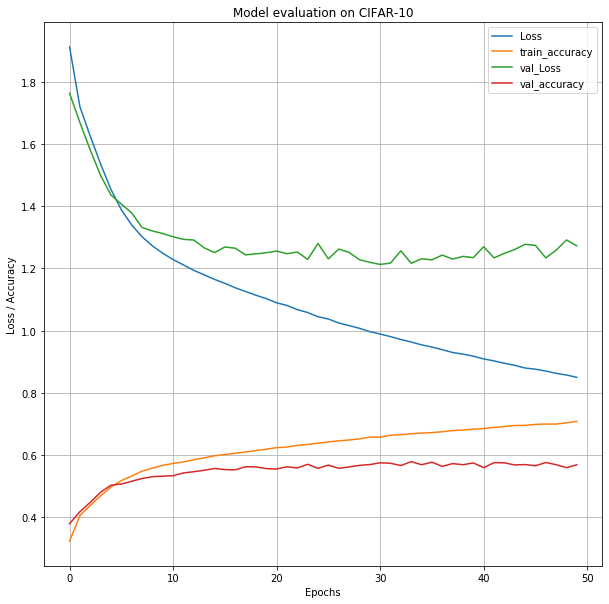

In [114]:
plot_model_evaluation(history)

In [119]:
model.save("train/shallownet.h5")

In [132]:
mo = keras.models.load_model("train/shallownet.h5")
pred = mo.predict(X_test)
print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

    classe_0       0.62      0.64      0.63      1000
    classe_1       0.69      0.72      0.71      1000
    classe_2       0.53      0.31      0.39      1000
    classe_3       0.43      0.29      0.35      1000
    classe_4       0.50      0.43      0.46      1000
    classe_5       0.48      0.52      0.50      1000
    classe_6       0.46      0.82      0.59      1000
    classe_7       0.72      0.58      0.64      1000
    classe_8       0.63      0.76      0.69      1000
    classe_9       0.63      0.62      0.63      1000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.56     10000
weighted avg       0.57      0.57      0.56     10000



## Learning rate decay : standard way 

In [138]:
model = ShallowNet.build(w, h, c, 10) 
epochs=50
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=0.01 / epochs) 
model.compile(optimizer=optimizer, metrics=["accuracy"], loss="CategoricalCrossentropy")
# fit : data, epoch, batch_size
history = model.fit(x=X_train,y=y_train, epochs=epochs, verbose=2, validation_data=(X_test, y_test))

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_15'), name='input_15', description="created by layer 'input_15'")
Epoch 1/50
1250/1250 - 5s - loss: 1.8534 - accuracy: 0.3468 - val_loss: 1.7300 - val_accuracy: 0.3925
Epoch 2/50
1250/1250 - 4s - loss: 1.6699 - accuracy: 0.4217 - val_loss: 1.6120 - val_accuracy: 0.4460
Epoch 3/50
1250/1250 - 4s - loss: 1.5849 - accuracy: 0.4557 - val_loss: 1.5481 - val_accuracy: 0.4574
Epoch 4/50
1250/1250 - 4s - loss: 1.5015 - accuracy: 0.4832 - val_loss: 1.4719 - val_accuracy: 0.4895
Epoch 5/50
1250/1250 - 5s - loss: 1.4266 - accuracy: 0.5092 - val_loss: 1.4169 - val_accuracy: 0.5041
Epoch 6/50
1250/1250 - 4s - loss: 1.3694 - accuracy: 0.5276 - val_loss: 1.3787 - val_accuracy: 0.5201
Epoch 7/50
1250/1250 - 4s - loss: 1.3270 - accuracy: 0.5420 - val_loss: 1.3493 - val_accuracy: 0.5224
Epoch 8/50
1250/1250 - 4s - loss: 1.2943 - accuracy: 0.5539 - val_loss: 1.3277 - val_accuracy: 0.5328
Epoch 9/50
1250/1250 - 4s - lo

In [139]:
preds = model.predict(X_val)
target_names = [f"classe_{i}" for i in range(len(y_test[0]))]
print(classification_report(y_val.argmax(axis=1), preds.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

    classe_0       0.61      0.61      0.61      1024
    classe_1       0.67      0.72      0.69      1017
    classe_2       0.42      0.45      0.43       944
    classe_3       0.42      0.32      0.36      1002
    classe_4       0.45      0.53      0.49       981
    classe_5       0.44      0.47      0.45       961
    classe_6       0.57      0.60      0.58       980
    classe_7       0.64      0.59      0.62       994
    classe_8       0.71      0.67      0.69      1035
    classe_9       0.67      0.64      0.65      1062

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       0.56      0.56      0.56     10000



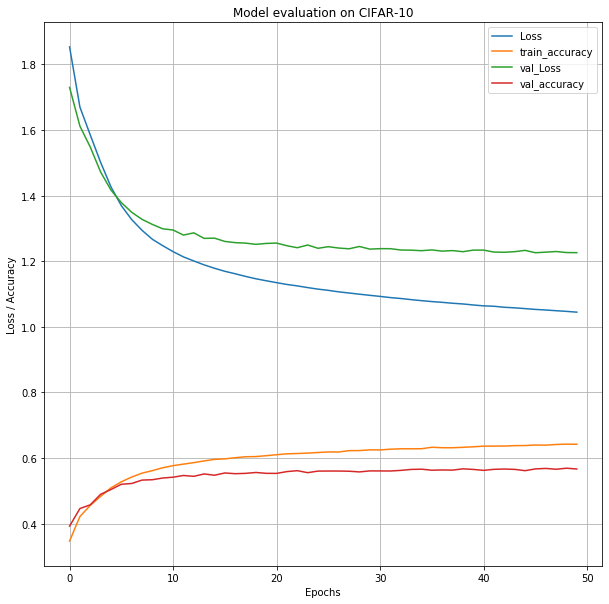

In [140]:
plot_model_evaluation(history) # We have reduced Over fitting

In [141]:
model.save("train/shallownet_decay.h5")

### Learning Rate : step based

In [71]:
def scheduler(epoch, lr): 
    if epoch < 17: 
        return lr
    else: 
        return lr * tf.math.exp(-0.05)

In [75]:
def training_loop_cifar(epochs, lr, batch_size, schedule): 
    
    model = ShallowNet.build(w, h, c, 10) 
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr) 
    model.compile(optimizer=optimizer, metrics=["accuracy"], loss="CategoricalCrossentropy")
    tf.math.round(model.optimizer.lr, 5)
    # callbacks 
    if schedule: 
        callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler)]
    else: 
        callbacks = []
    
    # fit : data, epoch, batch_size
    history = model.fit(x=X_train,y=y_train, epochs=epochs, verbose=5, validation_data=(X_test, y_test), callbacks=callbacks, batch_size=batch_size)
    
    preds = model.predict(X_val)
    target_names = [f"classe_{i}" for i in range(len(y_test[0]))]
    print(classification_report(y_val.argmax(axis=1), preds.argmax(axis=1), target_names=target_names))
    print()
    plot_model_evaluation(history, epoch, f"ep:{epochs};lr:{lr};bs{batch_size}") 
    print()
    model.save(f"train/shallownet_step_decay_{epoch}_{lr}_b{batch_size}.h5") 

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_44'), name='input_44', description="created by layer 'input_44'")
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
              precision    recall  f1-score   support

    classe_0       0.62      0.62      0.62      1057
    classe_1       0.70      0.72      0.71       974
    classe_2       0.47      0.47      0.47       991
    classe_3       0.44      0.38     

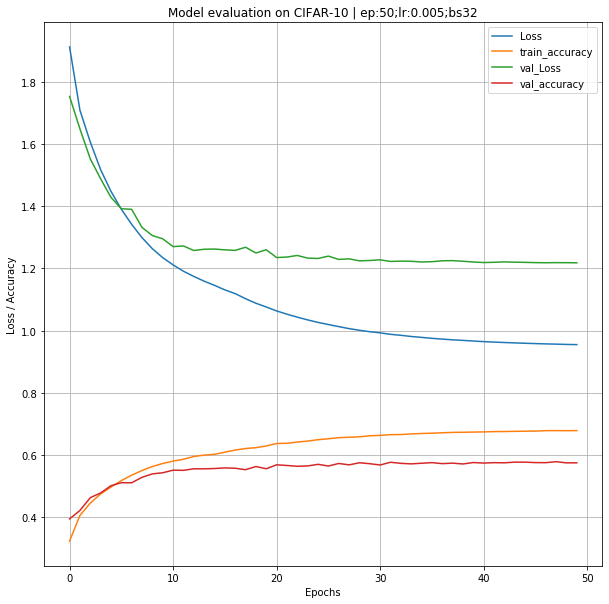


KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_45'), name='input_45', description="created by layer 'input_45'")
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
              precision    recall  f1-score   support

    classe_0       0.66      0.61      0.63      1057
    classe_1       0.72      0.75      0.73       974
    classe_2       0.49      0.44      0.47       991
    classe_3       0.43      0.42    

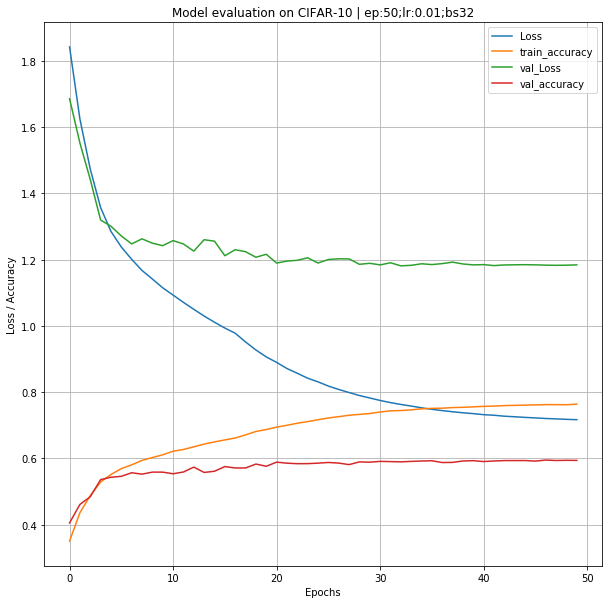


KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_46'), name='input_46', description="created by layer 'input_46'")
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
              precision    recall  f1-score   support

    classe_0       0.67      0.61      0.64      1057
    classe_1       0.78      0.66      0.71       974
    classe_2       0.39      0.63      0.48       991
    classe_3       0.41      0.44    

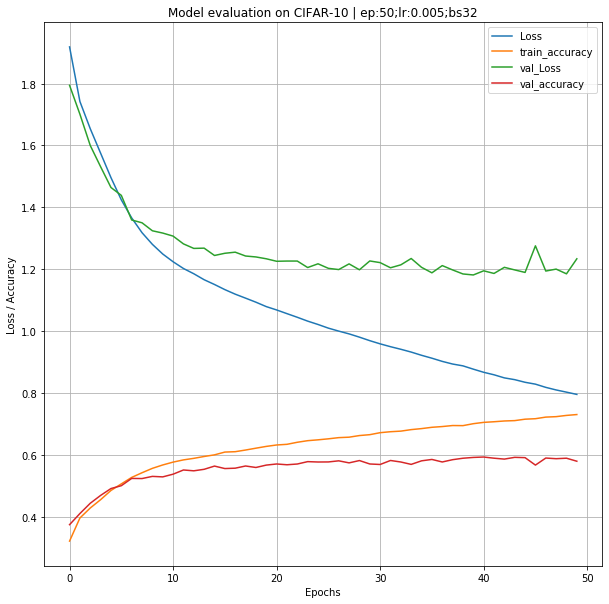


KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_47'), name='input_47', description="created by layer 'input_47'")
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
              precision    recall  f1-score   support

    classe_0       0.63      0.60      0.61      1057
    classe_1       0.76      0.72      0.74       974
    classe_2       0.43      0.52      0.47       991
    classe_3       0.46      0.31    

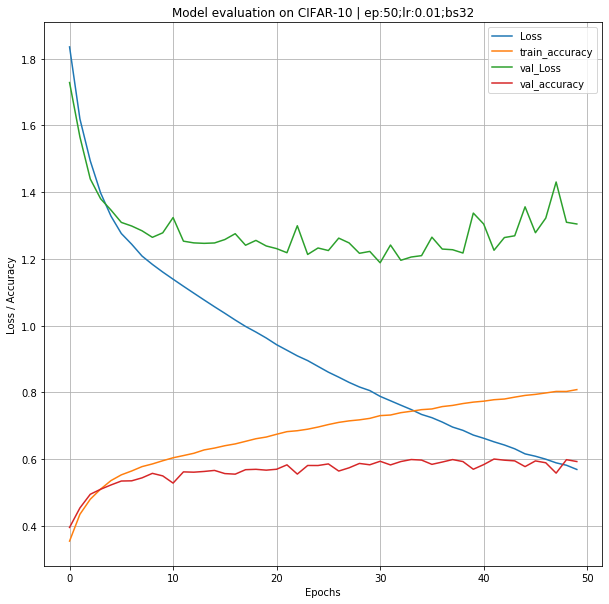

In [76]:
epochs = [50] 
lr = [0.005, 0.01]
schedule = [True, False]
batch_sizes = [32] 


for epoch in epochs: 
    for sc in schedule: 
        for l in lr: 
            for b_s in batch_sizes: 
                training_loop_cifar(epoch, l, b_s, sc)